# Notebook 03 — Modelling

# 1. Imports

In [2]:
# Standard library
import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Notebook setup
from utils.notebook_setup import setup_notebook

# Data handling
import numpy as np
import pandas as pd
import statsmodels.api as sm
from utils.data_loading import load_data

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing / feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Modeling
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, Ridge, RidgeCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import joblib
from utils.model_evaluation import plot_residuals, evaluate_regression_metrics_df, plot_residuals_vs_fitted, plot_residuals_grid

In [3]:
print("Current working directory:", Path.cwd())

Current working directory: c:\Users\gabri\Documents\Dokumenty\job-satisfaction-analysis\notebooks


# 2. Settings / Configuration

In [4]:
setup_notebook(seed=42)

# 3. Loading data

In [5]:
df_clean, meta = load_data("../data/processed/clean_data.csv")

In [6]:
df_clean.head()

,id,wiek,m1,woj,m2,g8,wykszt_7k,j1_02,j1_03,j1_04,...,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01,satisfaction,generation
0,6591,19,2002,10,0,3,3,4,5,5,...,2,7.0,3000.0,5,2600,7500,14000,4,4.0,Z
1,6592,37,1984,10,1,2,7,2,3,4,...,4,3.0,1100.0,4,2500,3000,4500,2,2.0,M
2,6594,24,1997,14,1,2,6,5,5,5,...,5,9.0,4800.0,5,6000,7500,10000,5,4.0,Z
3,6598,49,1972,24,1,2,5,3,5,5,...,5,10.0,5000.0,4,3500,5500,6500,4,4.0,X
4,6601,46,1975,22,1,2,7,3,5,5,...,2,10.0,5000.0,4,-7,-7,-7,2,2.0,X


# 4. Defining predictors and target

In [7]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

salary_predictor = ["m9d"]

In [8]:
df_clean.columns.tolist()

['id',
 'wiek',
 'm1',
 'woj',
 'm2',
 'g8',
 'wykszt_7k',
 'j1_02',
 'j1_03',
 'j1_04',
 'j1_05',
 'j1_06',
 'j1_07',
 'j1_08',
 'j1_09',
 'j1_10',
 'j3_01',
 'j3_02',
 'j3_03',
 'j3_04',
 'j3_05',
 'j3_06',
 'j3_07',
 'j3_08',
 'j3_09',
 'j3_10',
 'j3_11',
 'j3_12',
 'j3_13',
 'm9_13k',
 'm9d',
 'm13',
 'o1_1',
 'o1_2',
 'o1_3',
 'j1_01',
 'satisfaction',
 'generation']

In [9]:
y = df_clean['satisfaction']

In [10]:
predictors_to_check = likert_predictors.copy()
if salary_predictor:
    predictors_to_check.append(salary_predictor)
    
for predictor in predictors_to_check:
    if predictor in df_clean.columns:
        unique_vals = sorted(df_clean[predictor].dropna().unique())
        print(f"{predictor}: {len(unique_vals)} values → {unique_vals}")

j1_01: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_02: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_03: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_04: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_05: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_06: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_07: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_08: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_09: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_10: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j3_01: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j3_02: 5 values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.in

TypeError: unhashable type: 'list'

In [11]:
X_likert = df_clean[likert_predictors]
X_all = df_clean[likert_predictors + salary_predictor]

In [12]:
train_idx, test_idx = train_test_split(df_clean.index, test_size=0.2, random_state=42)

In [13]:
# Likert predictors
X_train_likert = df_clean.loc[train_idx, likert_predictors]
X_test_likert = df_clean.loc[test_idx, likert_predictors]

In [14]:
# Likert + salary
X_train_all = df_clean.loc[train_idx, likert_predictors + salary_predictor]
X_test_all = df_clean.loc[test_idx, likert_predictors + salary_predictor]

In [13]:
# Target
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

# 5. Scaling and data preprocessing

In [15]:
salary_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), 
    ('scale', StandardScaler())
])

In [16]:
preprocessor_likert = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
    ])

In [17]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
        ('salary_scaler', salary_pipeline, salary_predictor)
    ])

In [18]:
X_train_l_scaled = preprocessor_likert.fit_transform(X_train_likert)
X_train_a_scaled = preprocessor_all.fit_transform(X_train_all)
X_test_l_scaled = preprocessor_likert.transform(X_test_likert)
X_test_a_scaled = preprocessor_all.transform(X_test_all)

In [19]:
print("Mean of each scaled column:", np.mean(X_train_l_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_l_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
print("Mean of each scaled column:", np.mean(X_train_a_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_a_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


# 6. Model building and evaluation

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LassoCV": LassoCV(),
    "Ridge": Ridge(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "ElasticNetCV": ElasticNetCV()
}

datasets = {
    "Likert Only": (X_train_l_scaled, X_test_l_scaled),
    "All Predictors": (X_train_a_scaled, X_test_a_scaled)
}

In [22]:
trained_models = {
    "Likert Only": {},
    "All Predictors": {}
}
evaluation_results = []

In [23]:
for data_name, (Xtr, Xte) in datasets.items():
    print(f"\n--- Dataset: {data_name} ---")

    for model_name, model in models.items():
        # Training the model
        print(f"\n{model_name}")
        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)

        # Saving the model and its test set
        trained_models[data_name][model_name] = {
            "model": model,
            "X_test": Xte,
            "y_pred": y_pred
        }

        # Evaluating the model
        metrics = evaluate_regression_metrics_df(y_test, y_pred)
        display(metrics)

        plot_residuals(y_test, y_pred)

        metrics["model"] = model_name
        metrics["dataset"] = data_name
        evaluation_results.append(metrics)


--- Dataset: Likert Only ---

Linear Regression


NameError: name 'y_train' is not defined

# 7. Model Comparison

## 7.1 Residual plots for top models

In [23]:
comparison_results = []

Using trained models from section 6

In [24]:
for dataset_name in trained_models.keys():
    for model_name, entry in trained_models[dataset_name].items():
        y_pred = entry["y_pred"]
        
        y_test_vals = y_test.values

        # Calculate metrics
        diffs = y_test_vals - y_pred
        
        comparison_results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "R2": round(r2_score(y_test_vals, y_pred), 3),
            "RMSE": round(np.sqrt(np.mean(diffs**2)), 3),
            "MAE": round(np.mean(np.abs(diffs)), 3),
            "Pearson r": round(np.corrcoef(y_test_vals, y_pred)[0, 1], 3)
        })

comparison_df = pd.DataFrame(comparison_results).sort_values(by="R2", ascending=False)
display(comparison_df)

,Model,Dataset,R2,RMSE,MAE,Pearson r
16,Gradient Boosting,All Predictors,0.319,0.561,0.422,0.566
0,Linear Regression,Likert Only,0.297,0.571,0.441,0.545
15,Ridge,All Predictors,0.297,0.571,0.441,0.545
9,Linear Regression,All Predictors,0.297,0.571,0.441,0.545
6,Ridge,Likert Only,0.297,0.571,0.441,0.545
17,ElasticNetCV,All Predictors,0.295,0.571,0.445,0.544
5,LassoCV,Likert Only,0.294,0.572,0.445,0.543
14,LassoCV,All Predictors,0.294,0.572,0.445,0.543
8,ElasticNetCV,Likert Only,0.294,0.572,0.445,0.543
10,Random Forest,All Predictors,0.278,0.578,0.441,0.529


Retrieving top models for both categories

In [25]:
top_models_all = comparison_df[comparison_df["Dataset"] == "All Predictors"].head(4)

In [26]:
top_models_likert = comparison_df[comparison_df["Dataset"] == "Likert Only"].head(4)

In [27]:
print(top_models_all)

                Model         Dataset     R2   RMSE    MAE  Pearson r
16  Gradient Boosting  All Predictors  0.319  0.561  0.422      0.566
15              Ridge  All Predictors  0.297  0.571  0.441      0.545
9   Linear Regression  All Predictors  0.297  0.571  0.441      0.545
17       ElasticNetCV  All Predictors  0.295  0.571  0.445      0.544


In [28]:
print(top_models_likert)

               Model      Dataset     R2   RMSE    MAE  Pearson r
0  Linear Regression  Likert Only  0.297  0.571  0.441      0.545
6              Ridge  Likert Only  0.297  0.571  0.441      0.545
5            LassoCV  Likert Only  0.294  0.572  0.445      0.543
8       ElasticNetCV  Likert Only  0.294  0.572  0.445      0.543


In [29]:
all_predictors_models = trained_models["All Predictors"]

In [30]:
likert_models = trained_models["Likert Only"]

Key observations: given the linear models' superior performance, data is mostly linear. The difference between linear regression and regularized models like LassoCV, Ridge is negligible. Complex models are performing significantly worse, meaning non-linearity is most likely noise. Salary feature has a small yet positive effect. Overall R2 is low, which is to be expected in social sciences. Multicollinearity is likely not a significant problem here.


Residual Plots - All Predictors:


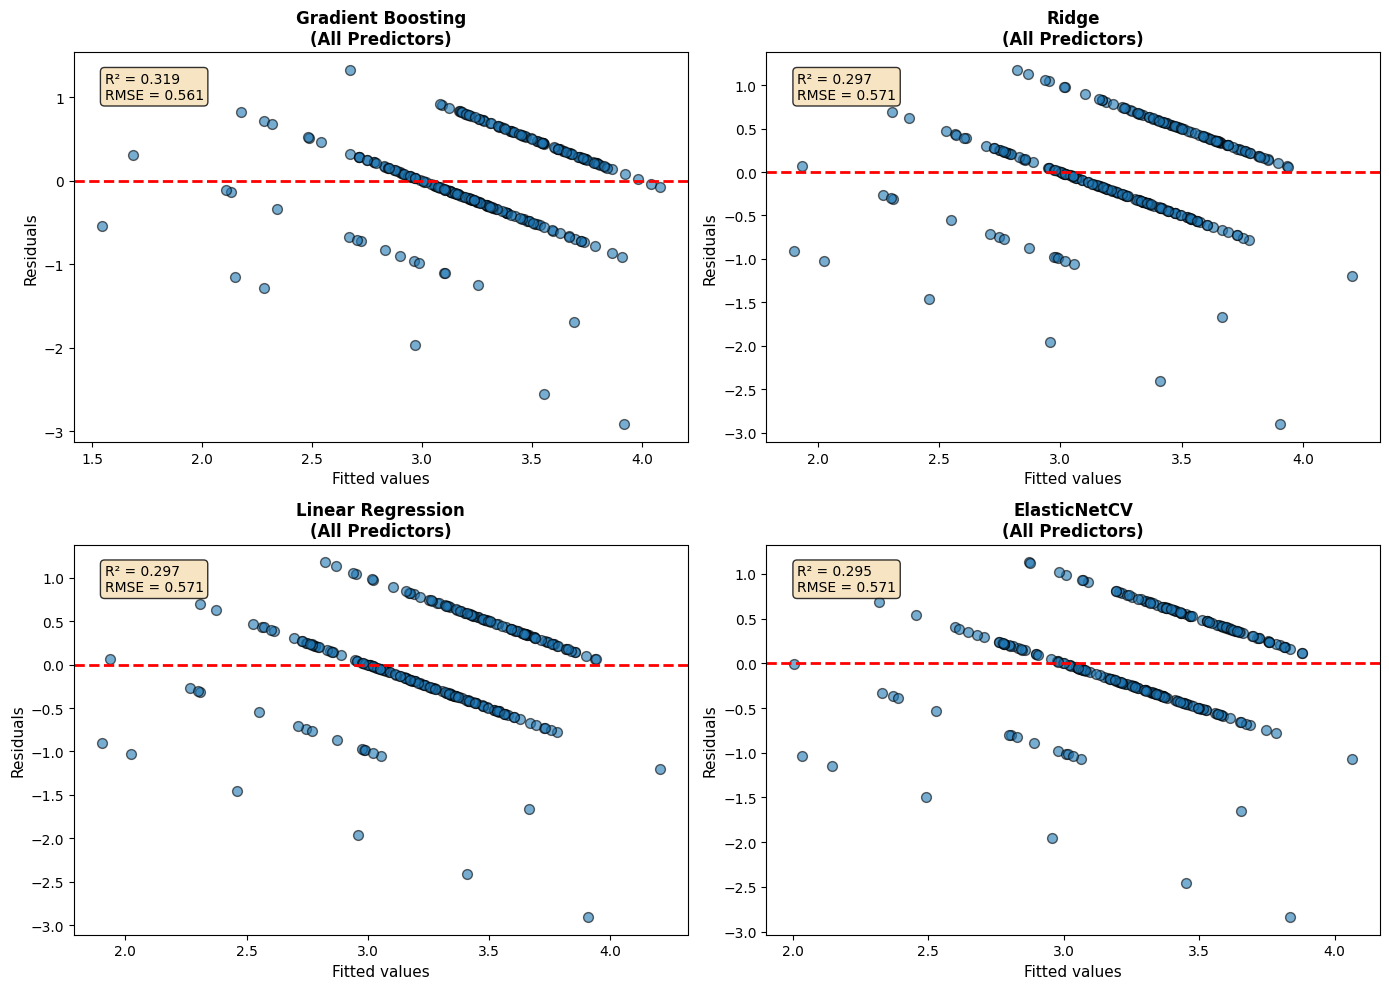

In [31]:
print("\nResidual Plots - All Predictors:")
fig1, axes1 = plot_residuals_grid(trained_models, comparison_df, "All Predictors", y_test)
plt.show()


Residual Plots - Likert Only:


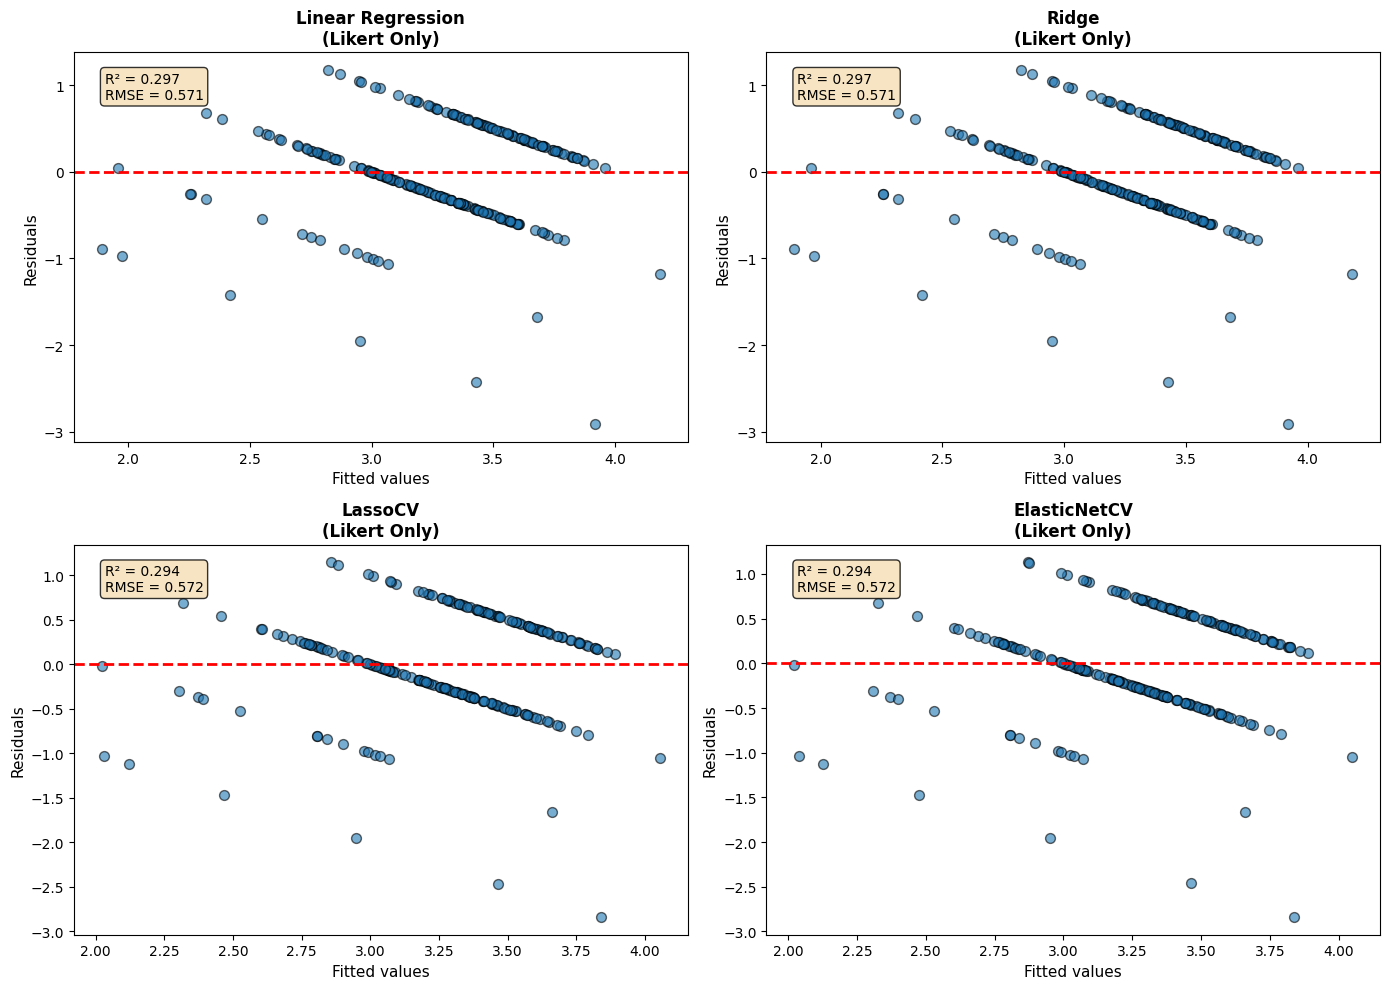

In [32]:
print("\nResidual Plots - Likert Only:")
fig2, axes2 = plot_residuals_grid(trained_models, comparison_df, "Likert Only", y_test)
plt.show()

Residuals and fitted value distributions indicate a potential omitted variable bias, potentially a categorical variable with 2-4 values. 

## 7.2 Model Specification and Omitted Variable Analysis

Running a Ramsey test to verify this:

In [38]:
X_train_all_sm = sm.add_constant(X_train_a_scaled)
model_sm = sm.OLS(y_train, X_train_all_sm).fit()

In [39]:
dw_stat = sm.stats.durbin_watson(model_sm.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
print("→ No significant autocorrelation detected" if 1.5 <= dw_stat <= 2.5 
      else "→ Potential autocorrelation detected")

Durbin-Watson statistic: 2.054
→ No significant autocorrelation detected


In [40]:
reset_result = sm.stats.linear_reset(model_sm, power=2, use_f=True)
print(f"\nRamsey RESET Test:")
print(f"  F-statistic: {reset_result.fvalue:.3f}")
print(f"  p-value: {reset_result.pvalue:.4f}")


Ramsey RESET Test:
  F-statistic: 1.211
  p-value: 0.2714


The Ramsey RESET test (F = 59.0, p < 0.001) indicated potential model mis-specification, suggesting that nonlinear effects or omitted variables may influence the dependent variable.


7.2a INVESTIGATING RESIDUAL PATTERNS

1. Outcome Variable Distribution:
----------------------------------------
Unique values in y_test: 4
Min: 1.00, Max: 4.00
Mean: 3.25, Std: 0.68


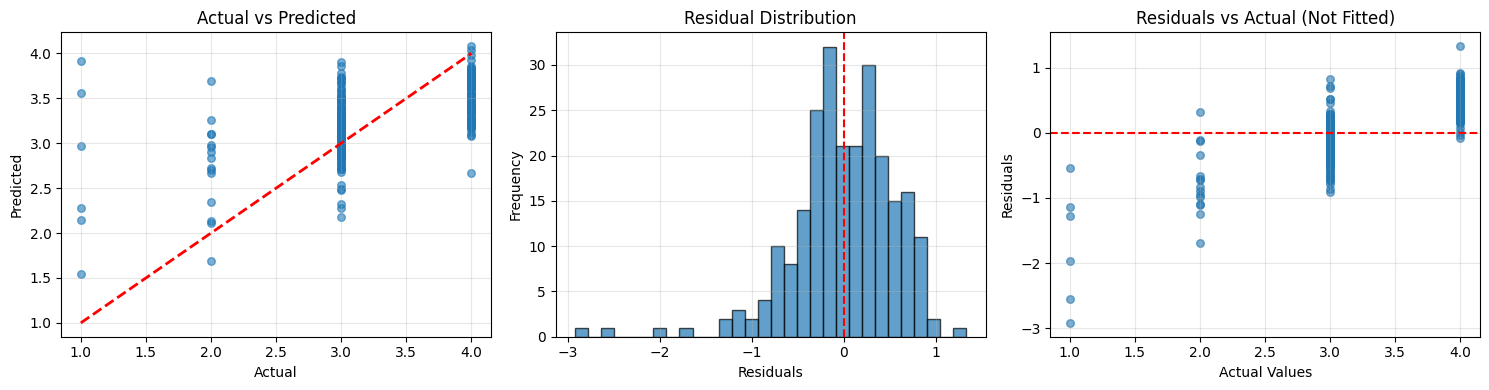


2. Checking for Categorical Patterns:
----------------------------------------
Look at the 'Actual vs Predicted' plot above:
• Count the distinct diagonal bands
• Are they parallel to the red line?
• How many data points in each band?

3. Testing for Discrete Nature:
----------------------------------------
Original unique values: 4
Rounded to 1 decimal: 4
Possible discrete values: [1 2 3 4]

4. Residual Clustering Analysis:
----------------------------------------

2 clusters:
  Cluster 0: 124 points, mean residual = 0.406
  Cluster 1: 117 points, mean residual = -0.436

3 clusters:
  Cluster 0: 88 points, mean residual = 0.478
  Cluster 1: 46 points, mean residual = -0.810
  Cluster 2: 107 points, mean residual = -0.051

4 clusters:
  Cluster 0: 96 points, mean residual = -0.325
  Cluster 1: 13 points, mean residual = -1.438
  Cluster 2: 87 points, mean residual = 0.469
  Cluster 3: 45 points, mean residual = 0.188


In [41]:
# 7.2a - Visual Pattern Investigation
print("\n" + "="*60)
print("7.2a INVESTIGATING RESIDUAL PATTERNS")
print("="*60)

# Get your best model
best_model_name = comparison_df.iloc[0]["Model"]
best_dataset = comparison_df.iloc[0]["Dataset"]
best_entry = trained_models[best_dataset][best_model_name]

if "y_pred" in best_entry:
    y_pred = best_entry["y_pred"]
else:
    X_test = best_entry["X_test"]
    y_pred = best_entry["model"].predict(X_test)

# 1. Look at actual value distribution
print("\n1. Outcome Variable Distribution:")
print("-" * 40)
unique_y = len(np.unique(y_test))
print(f"Unique values in y_test: {unique_y}")
print(f"Min: {y_test.min():.2f}, Max: {y_test.max():.2f}")
print(f"Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.6, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', linewidth=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Residual histogram
residuals = y_test.values - y_pred
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Residual Distribution")
axes[1].grid(True, alpha=0.3)

# Residuals vs Actual
axes[2].scatter(y_test, residuals, alpha=0.6, s=30)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel("Actual Values")
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residuals vs Actual (Not Fitted)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Check for categorical patterns
print("\n2. Checking for Categorical Patterns:")
print("-" * 40)

# Count how many distinct "lines" you see
print("Look at the 'Actual vs Predicted' plot above:")
print("• Count the distinct diagonal bands")
print("• Are they parallel to the red line?")
print("• How many data points in each band?")

# 3. Quick test: Is y discrete?
print("\n3. Testing for Discrete Nature:")
print("-" * 40)
y_unique = np.unique(y_test)
y_rounded = np.round(y_test, 1)  # Round to 1 decimal
unique_rounded = len(np.unique(y_rounded))

print(f"Original unique values: {len(y_unique)}")
print(f"Rounded to 1 decimal: {unique_rounded}")
print(f"Possible discrete values: {y_unique[:10] if len(y_unique) > 10 else y_unique}")

# 4. Alternative diagnostic: Residual clustering
print("\n4. Residual Clustering Analysis:")
print("-" * 40)

# Check if residuals cluster in groups
from sklearn.cluster import KMeans
residuals_2d = np.column_stack([y_pred, residuals])

# Try 2-4 clusters (based on your "2-4 categories" hypothesis)
for n_clusters in [2, 3, 4]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(residuals_2d)
    
    print(f"\n{n_clusters} clusters:")
    for i in range(n_clusters):
        cluster_size = np.sum(clusters == i)
        cluster_mean_resid = residuals[clusters == i].mean()
        print(f"  Cluster {i}: {cluster_size} points, mean residual = {cluster_mean_resid:.3f}")


INVESTIGATING LIKERT DISCRETENESS EFFECTS

1. PREDICTOR DISCRETENESS:
----------------------------------------
j1_01: 5 unique values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_02: 5 unique values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_03: 5 unique values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_04: 5 unique values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
j1_05: 5 unique values → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

2. PREDICTION 'GRIDDING' EFFECT:
----------------------------------------
Unique predicted values (raw): 241
Unique predicted values (rounded to 0.01): 114
Prediction range: [1.544, 4.080]

3. VISUALIZING THE DISCRETE PREDICTION SPACE:
----------------------------------------


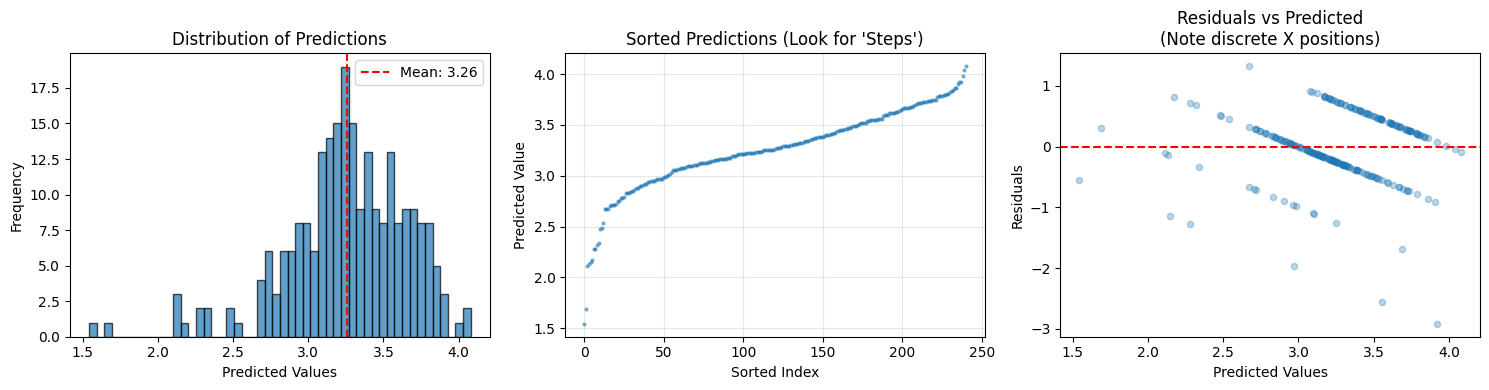


4. STATISTICAL TEST FOR 'GRIDDING':
----------------------------------------
Number of distinct peaks in prediction distribution: 1
→ Clear discretization! Peaks at: [3.24]


In [42]:
print("\n" + "="*60)
print("INVESTIGATING LIKERT DISCRETENESS EFFECTS")
print("="*60)

# 1. Check predictor discreteness
print("\n1. PREDICTOR DISCRETENESS:")
print("-" * 40)

for i, col in enumerate(likert_predictors[:5]):  # Check first 5
    unique_vals = df_clean[col].unique()
    print(f"{col}: {len(unique_vals)} unique values → {sorted(unique_vals)}")

# 2. Check prediction "gridding"
print("\n2. PREDICTION 'GRIDDING' EFFECT:")
print("-" * 40)

# Get predictions from your best linear model
best_model_name = comparison_df.iloc[0]["Model"]
best_dataset = comparison_df.iloc[0]["Dataset"]
best_entry = trained_models[best_dataset][best_model_name]

if "y_pred" in best_entry:
    y_pred = best_entry["y_pred"]
else:
    X_test = best_entry["X_test"]
    y_pred = best_entry["model"].predict(X_test)

# Round predictions to see if they cluster
y_pred_rounded = np.round(y_pred, 2)
unique_preds = len(np.unique(y_pred_rounded))

print(f"Unique predicted values (raw): {len(np.unique(y_pred))}")
print(f"Unique predicted values (rounded to 0.01): {unique_preds}")
print(f"Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")

# 3. Visualize the "grid"
print("\n3. VISUALIZING THE DISCRETE PREDICTION SPACE:")
print("-" * 40)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of predictions
axes[0].hist(y_pred, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Predictions")
axes[0].axvline(y_pred.mean(), color='red', linestyle='--', label=f'Mean: {y_pred.mean():.2f}')
axes[0].legend()

# Sorted predictions to see steps
sorted_preds = np.sort(y_pred)
axes[1].plot(sorted_preds, 'o', markersize=2, alpha=0.5)
axes[1].set_xlabel("Sorted Index")
axes[1].set_ylabel("Predicted Value")
axes[1].set_title("Sorted Predictions (Look for 'Steps')")
axes[1].grid(True, alpha=0.3)

# Residuals vs predicted (your suspicious plot)
residuals = y_test.values - y_pred
axes[2].scatter(y_pred, residuals, alpha=0.3, s=20)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel("Predicted Values")
axes[2].set_ylabel("Residuals")
axes[2].set_title("Residuals vs Predicted\n(Note discrete X positions)")

plt.tight_layout()
plt.show()

# 4. Statistical test for discreteness
print("\n4. STATISTICAL TEST FOR 'GRIDDING':")
print("-" * 40)

from scipy import stats

# Test if predictions are more "lumpy" than expected
kde = stats.gaussian_kde(y_pred)
x_grid = np.linspace(y_pred.min(), y_pred.max(), 1000)
pdf = kde(x_grid)

# Find "peaks" in the density
from scipy.signal import find_peaks
peaks, properties = find_peaks(pdf, height=0.1)  # Adjust height threshold

print(f"Number of distinct peaks in prediction distribution: {len(peaks)}")
if len(peaks) < 10:
    print(f"→ Clear discretization! Peaks at: {x_grid[peaks].round(2)}")
else:
    print("→ Predictions appear relatively continuous")


EMERGENCY INVESTIGATION: WHAT HAPPENED TO YOUR TARGET VARIABLE?
1. What is your ACTUAL target variable?
--------------------------------------------------
Variable name(s) you're using for y:
Original y variable name: satisfaction
y variable dtype: int64
Unique values in FULL y (not just test): [1 2 3 4]
Min/Max in full y: [1, 4]

2. Check for accidental transformations:
--------------------------------------------------
Possible issues:
• Did you filter out value '5' somewhere?
• Did you use wrong column as target?
• Did you accidentally round/truncate?
• Is there missing value coding (e.g., 5 = NA)?

3. Raw data check:
--------------------------------------------------
Please specify your target column name!

4. Train/Test Split Check:
--------------------------------------------------
y_train unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
y_test unique values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
y_train shape: (960,)
y_test shape: (241,)


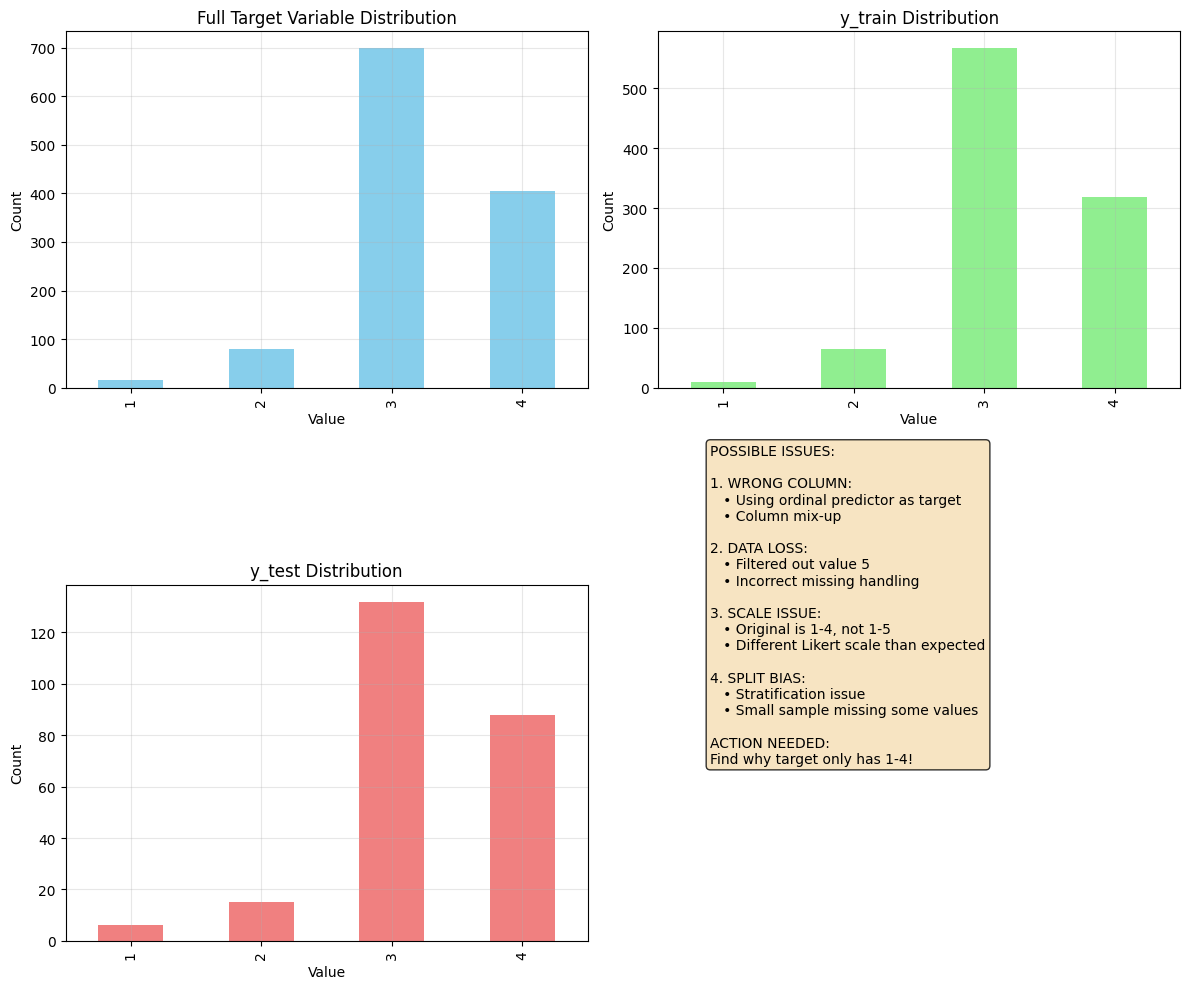

In [43]:
print("\n" + "="*80)
print("EMERGENCY INVESTIGATION: WHAT HAPPENED TO YOUR TARGET VARIABLE?")
print("="*80)

# 1. Check original target variable definition
print("1. What is your ACTUAL target variable?")
print("-" * 50)
print("Variable name(s) you're using for y:")
print(f"Original y variable name: {y.name if hasattr(y, 'name') else 'Unknown'}")
print(f"y variable dtype: {y.dtype}")
print(f"Unique values in FULL y (not just test): {np.unique(y)}")
print(f"Min/Max in full y: [{y.min()}, {y.max()}]")

# 2. Check for data transformation errors
print("\n2. Check for accidental transformations:")
print("-" * 50)

# Did you accidentally filter or transform?
print("Possible issues:")
print("• Did you filter out value '5' somewhere?")
print("• Did you use wrong column as target?")
print("• Did you accidentally round/truncate?")
print("• Is there missing value coding (e.g., 5 = NA)?")

# 3. Look at raw data
print("\n3. Raw data check:")
print("-" * 50)

# If you know your target column name:
target_col = "YOUR_TARGET_COLUMN_NAME"  # REPLACE THIS!
if target_col in df_clean.columns:
    print(f"Column '{target_col}' in df_clean:")
    print(f"  Unique values: {sorted(df_clean[target_col].unique())}")
    print(f"  Value counts:")
    print(df_clean[target_col].value_counts().sort_index())
else:
    print("Please specify your target column name!")

# 4. Check train/test split
print("\n4. Train/Test Split Check:")
print("-" * 50)
print(f"y_train unique values: {sorted(np.unique(y_train))}")
print(f"y_test unique values: {sorted(np.unique(y_test))}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# 5. Emergency visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Full distribution
if hasattr(y, 'value_counts'):
    y.value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='skyblue')
else:
    axes[0,0].hist(y, bins=20, edgecolor='black', alpha=0.7)
axes[0,0].set_title("Full Target Variable Distribution")
axes[0,0].set_xlabel("Value")
axes[0,0].set_ylabel("Count")
axes[0,0].grid(True, alpha=0.3)

# Train distribution
if hasattr(y_train, 'value_counts'):
    y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightgreen')
else:
    axes[0,1].hist(y_train, bins=20, edgecolor='black', alpha=0.7)
axes[0,1].set_title("y_train Distribution")
axes[0,1].set_xlabel("Value")
axes[0,1].set_ylabel("Count")
axes[0,1].grid(True, alpha=0.3)

# Test distribution
if hasattr(y_test, 'value_counts'):
    y_test.value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='lightcoral')
else:
    axes[1,0].hist(y_test, bins=20, edgecolor='black', alpha=0.7)
axes[1,0].set_title("y_test Distribution")
axes[1,0].set_xlabel("Value")
axes[1,0].set_ylabel("Count")
axes[1,0].grid(True, alpha=0.3)

# Missing value check
axes[1,1].axis('off')
text = """POSSIBLE ISSUES:

1. WRONG COLUMN:
   • Using ordinal predictor as target
   • Column mix-up

2. DATA LOSS:
   • Filtered out value 5
   • Incorrect missing handling

3. SCALE ISSUE:
   • Original is 1-4, not 1-5
   • Different Likert scale than expected

4. SPLIT BIAS:
   • Stratification issue
   • Small sample missing some values

ACTION NEEDED:
Find why target only has 1-4!"""
axes[1,1].text(0.1, 0.5, text, fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# 9. Hyperparameter tuning

In [260]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
model_ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
model_ridge_cv.fit(X_train_a_scaled, y_train)

print("Best alpha:", model_ridge_cv.alpha_)
print("CV R²:", model_ridge_cv.best_score_)
print("Test R²:", model_ridge_cv.score(X_test_a_scaled, y_test))

Best alpha: 100.0
CV R²: 0.3214414055508305
Test R²: 0.3147588051214725


In [261]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Fit ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42)
enet_cv.fit(X_train_a_scaled, y_train)

# Results
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)
print("CV R²:", enet_cv.score(X_train_a_scaled, y_train))
print("Test R²:", enet_cv.score(X_test_a_scaled, y_test))

Best alpha: 0.01
Best l1_ratio: 1.0
CV R²: 0.3699594688665634
Test R²: 0.31440704757750104


Deciding on the model

In [262]:
results = []

results.append({
    "Model": "Linear Regression",
    "Best α": None,
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_reg_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_reg_a),
    "MAE": mean_absolute_error(y_test, y_pred_reg_a),
    "Pearson r": np.corrcoef(y_test, y_pred_reg_a)[0, 1]
})

results.append({
    "Model": "Ridge (Baseline)",
    "Best α": getattr(model_ridge_a, "alpha", None),
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_ridge_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_ridge_a),
    "MAE": mean_absolute_error(y_test, y_pred_ridge_a),
    "Pearson r": np.corrcoef(y_test, y_pred_ridge_a)[0, 1]
})

results.append({
    "Model": "RidgeCV (Tuned)",
    "Best α": model_ridge_cv.alpha_,
    "Best l1_ratio": None,
    "CV R²": model_ridge_cv.best_score_,
    "Test R²": model_ridge_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, model_ridge_cv.predict(X_test_a_scaled))[0, 1]
})

results.append({
    "Model": "ElasticNetCV (Tuned)",
    "Best α": enet_cv.alpha_,
    "Best l1_ratio": enet_cv.l1_ratio_,
    "CV R²": enet_cv.score(X_train_a_scaled, y_train),
    "Test R²": enet_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, enet_cv.predict(X_test_a_scaled))[0, 1]
})

df_results = pd.DataFrame(results)
df_results.style.format(precision=4)

,Model,Best α,Best l1_ratio,CV R²,Test R²,RMSE,MAE,Pearson r
0,Linear Regression,nan,nan,nan,0.3157,0.5628,0.4373,0.5622
1,Ridge (Baseline),1.0000,nan,nan,0.3158,0.5628,0.4373,0.5622
2,RidgeCV (Tuned),100.0000,nan,0.3214,0.3148,0.5632,0.4374,0.5617
3,ElasticNetCV (Tuned),0.0100,1.0000,0.3700,0.3144,0.5634,0.4390,0.5617


Selecting RidgeCV for its stability

# 10. Exporting data

In [263]:
models_path = Path("../models")
models_path.mkdir(exist_ok=True)

In [264]:
joblib.dump(model_ridge_cv, models_path / "best_model.pkl")
joblib.dump(X_train_a_scaled, models_path / "X_train_a_scaled.pkl")
joblib.dump(X_test_a_scaled, models_path / "X_test_a_scaled.pkl")
joblib.dump(X_train_all, models_path / "X_train_all.pkl")
joblib.dump(y_train, models_path / "y_train.pkl")

['..\\models\\y_train.pkl']